## Cluster Analysis

We now continue with our theme of using unsupervised machine learning to discover patterns in our data. Suppose that we wish to create targeted promotions to increase our sales. How should we target our customers with the appropriate promotions? In order to maximize our sales, we probably do not wish to use the same promotion across our entire customer population - different customer populations will respond to promotions in different ways. Therefore, we must divide up our customer population into *segments* and choose the appropriate promotion for each one. **Cluster Analysis** can help us identify the patterns in our customer populations and help us to select these segments.

### Clustering Customers to Identify Segments

In order to learn how to perform cluster analysis, we are going to start by working on some computer-generated customer data, as real customer data is generally very messy and would be a confusing starting point. 

Suppose that we run an airline company and have a record of the number of tickets purchased by each customer and the average price that the customer paid for each ticket. 

In [1]:
import pandas as pd
airline_df = pd.read_csv("data/airline-data.csv")
airline_df.head()

,Avg Ticket Price ($),# of Tickets Purchased (last 12 months)
0,673.10,5
1,830.73,8
2,414.14,6
3,685.68,3
4,386.67,6


We could plot this data as shown below, using the pandas DataFrame's convenient wrapper method around matplotlib:

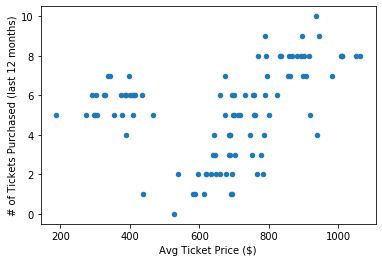

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

airline_df.plot.scatter(
    "Avg Ticket Price ($)",
    "# of Tickets Purchased (last 12 months)"
)
plt.show()

What are we to make of the graph above? Some clusters of customers look well-defined; others are fuzzy. We would like to save ourselves the effort of interpreting this graph manually and instead just use machine learning to group our customers into clusters. We can do this using the $k$-means algorithm, which we can instruct to partition our data into $k$ clusters. Since it looks like there are at least two clusters in the data above, let's try running $k$-means with $k=2$:

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

k = 2
# we standardize our data, as we did in the lesson on PCA
scaler = StandardScaler()
points_scaled = scaler.fit_transform(airline_df)
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(points_scaled)

Let's examine the cluster labels that were assigned to each of our customer data points: 

In [4]:
labels

array([1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], dtype=int32)

We see that each of our customers has been classified either into cluster `0` or cluster `1`. We can now use the code below to plot these results in an elegant form:


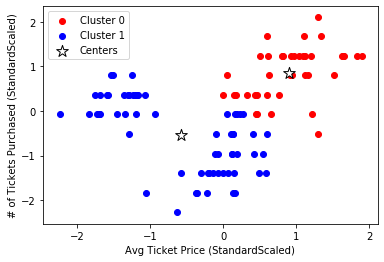

In [5]:
# Arguments: 
#   points_scaled (our StandardScaled datapoints)
#   labels (cluster labels (from kmeans object))
#   cluster_centers (center points of the clusters (from kmeans object))
def plot_clusters(points_scaled, labels, cluster_centers):
    colors = ["r", "b", "g", "y", "m","k"]
    
    n_clusters = len(cluster_centers)
    legends = []
    for i in range(0,n_clusters):
        label_filter = (labels == i)
        plt.scatter(points_scaled[label_filter, 0], points_scaled[label_filter, 1], color=colors[i])
        legends.append(f"Cluster {i}")
    plt.scatter(cluster_centers[:,0], cluster_centers[:,1], marker="*", c="w", edgecolors="k",s=150)
    legends.append("Centers")
    plt.xlabel("Avg Ticket Price (StandardScaled)")
    plt.ylabel("# of Tickets Purchased (StandardScaled)")
    plt.legend(legends)
    plt.show()
plot_clusters(points_scaled, labels, kmeans.cluster_centers_)

In the graph above, the center of each cluster that the $k$-means algorithm calculated for us is indicated by a star, while the points for each cluster are highlighted with the corresponding color. 

These clusters do not look quite right - in particular, the blue cluster looks like it is actually two different clusters. We can improve our picture by increasing the cluster count *k*: 

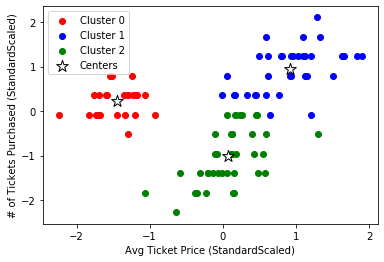

In [6]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(points_scaled)
plot_clusters(points_scaled, labels, kmeans.cluster_centers_)

This result certainly looks better - but "looks better" is not a sufficiently rigorous measure of performance. How should we quantitatively assess the right choice for the cluster count *k*? The standard way to tell if our clusters are "good" is to calculate the "within-cluster sum of squares" (WCSS) to gauge how "spread out" our clusters are. This means that for every cluster, we loop over every point in that cluster and compute the square of the distance from that point to the center of the cluster. We then add up all of these squared distances to get the final WCSS value for that cluster. 

In [7]:
from numpy.linalg import norm

def wcss(points, center):
    total = 0 
    for point in points:
        d = norm(point - center)
        total += d*d
    return total

Let's evaluate the spread of our first cluster:

In [8]:
wcss(points_scaled[labels == 0, :], kmeans.cluster_centers_[0])

4.627474187680641

We can compare this value to the WCSS for our third cluster:

In [9]:
wcss(points_scaled[labels == 2, :], kmeans.cluster_centers_[2])

21.273957320823776

So our third cluster is much less "spread out" than our first cluster. This makes sense; we can see from our graph that the first (red) cluster is the most spread out, and could probably be broken down into a number of smaller clusters. The `kmeans` object that we created earlier contains the sum of all WCSS values for every cluster in the `inertia_` attribute:

In [10]:
kmeans.inertia_

43.792214303613854

The `inertia_` number above is the total "spread" of all of our clusters combined. Choosing a larger value of $k$ will create a larger number of smaller clusters, and so this `inertia_` value will decline. If we chose a number of clusters equal to the number of points in our dataset, the `inertia_` value would be zero. However, we would then have no clusters at all, only points, and we thus would derive no value from this analysis. The trick to doing cluster analysis well is to find a value for $k$ that is not too large (keeping the cluster count small), but that results in a small spread for each cluster. How do we find this optimal $k$ value? We simply start with $k = 1$, and then increase $k$ until the `inertia_` value levels out.

<span style="color:blue;font-weight:bold">Exercise</span>: Create an *elbow plot* to measure how the `inertia_` value decreases with increasing cluster count. You should construct this plot using the following steps:

1. Vary the value of $k$ from `1` to `6`, perform $k$-means clustering for each value of $k$, and record the `inertia_` value for that set of clusters. Store the resulting list in the variable `inertia_values`. Note - you must pass the `random_state=0` argument to the `KMeans` function in order for your solution to validate.

2. Use matplotlib to make a line plot of `inertia_` vs $k$, and choose the best value for $k$ based on this plot. Store this $k$ value in the variable `optimal_k` 

Remember to use `points_scaled`, rather than `points`, when performing your analysis!

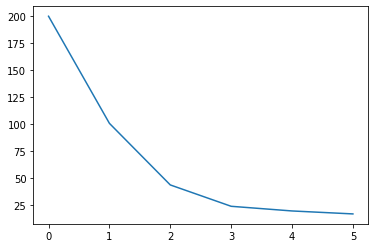

In [14]:
random_state = 0

inertia_values = []
for k in range(1, 7):
    km = KMeans(n_clusters=k, random_state=random_state)
    km.fit(points_scaled)
    inertia_values.append(km.inertia_)
    
plt.plot(inertia_values)

optimal_k=4

In [14]:
import math
check_variable_definition("optimal_k")
assert isinstance(inertia_values, list), "<code>inertia_values</code> should be a list</code>"
assert len(inertia_values) == 6, "Your <code>inertia_values</code> list has the wrong length - did you test all values of k from 1 to 6?"
assert optimal_k == 4, "Your <code>optimal_k</code> value is incorrect - take another look at your elbow plot."
success()

<span style="color:blue;font-weight:bold">Exercise</span>:  Using the optimal value of $k$ that you determined from the graph above, compute a new set of clusters and plot these clusters using the `plot_clusters` function as shown above. You must use the variable `optimal_clusters` to store your model object and pass `random_state=0` to the `KMeans` function in order for your solution to successfully validate.

In [16]:
optimal_clusters = KMeans(n_clusters=optimal_k, random_state=0)
optimal_clusters.fit(points_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

In [16]:
import sklearn
check_variable_definition("optimal_clusters")
wrong_value_hint =  "The value that you stored in <code>optimal_clusters</code> is not correct - double-check your call to <code>KMeans</code>"
assert isinstance(optimal_clusters, sklearn.cluster.KMeans),wrong_value_hint
assert optimal_clusters.cluster_centers_.shape == (4,2), "You appear to have the wrong number of clusters in your <code>kmeans</code> object - did you choose <code>optimal_k</code> correctly in the previous exercise?"
success()

Now that you have performed a high-quality cluster analysis, it is time to consider the real-world meaning of your results. What market segment do you think each cluster corresponds to? Is one of your clusters business travellers? Economy tourism travellers? If you were running an airline, how would you tune your marketing for each group?

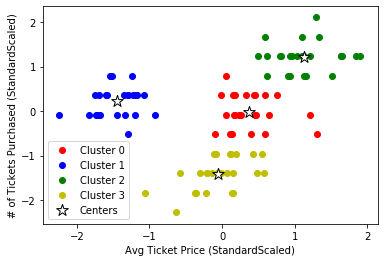

In [19]:
plot_clusters(points_scaled=points_scaled, 
              labels=optimal_clusters.labels_, 
              cluster_centers=optimal_clusters.cluster_centers_)